---

## 14 - Introduction to Frequency Planning
In this notebook, we investigate spurs resulting from the data conversion process and how they can be calculated. We first discuss how non-linear responses can cause harmonics, using an example of a non-linear amplifier, then go on to look at interleaving ADCs and how mismatches can result in a variety of spurs across the spectrum. We discuss the effects of aliasing and how it affects frequency planning for ADCs due to spurs folding into the Nyquist band. We then go on to simulate a non-linear interleaved ADC and compare the practical results with the theory. Finally, we touch on designing filters to sufficiently suppress spurs close to the signal of interest.

## Table of Contents

* [1. Introduction](#introduction)
* [2. Effects of Non-Linearity](#non_lin)
* [3. ADC Interleaving Spurs](#il_spurs)
    * [3.1. DC Offset Interleaving Spurs](#dc_offset)
    * [3.2. Gain/Time Interleaving Spurs](#gain_time)
    * [3.3. Harmonic Interleaving Spurs](#harmonic)
* [4. Aliasing](#alias)
* [5. Simulating a Non-Linear Interleaved ADC](#sim)
* [6. Filter Design](#filt_design)
* [7. Conclusion](#conclusion)
    
---

## 1. Introduction <a class="anchor" id="introduction"></a>
Frequency planning is a radio design technique used to avoid spurious emissions that may interfere with a signal of interest. It is based on the idea that the frequency content of many spurs are deterministic and readily computable given a set of input parameters. This means that a radio designer can choose parameters that result in the least interference with the signal of interest before committing to a specific configuration.

## 2. Effects of Non-Linearity <a class="anchor" id="non_lin"></a>

A linear amplifier will provide exactly linear gain across its entire operating range, meaning that the output of a device will be exactly proportionate to the input signal across all amplitudes. The output of a linear amplifier with a constant gain coefficient, $a$, can be expressed by

$$y = ax.$$

The output of a non-linear device on the other hand will not be proportionate for all input amplitudes and can be expressed by

$$a_1x + a_2x^2 + a_3x^3 ... + a_nx^n.$$

$a_1$, $a_2$... are not parameters a user can control, rather they are coefficients used to model the physical properties of the amplifier. The ideal scenario is that $a_2$ and above will be equal to zero. However, in practice they will have non-zero (but usually small) values.

Let's look at how a non-linear response can affect the output of an amplifier.

First we set the non-linear coefficients of the amplifier. In this example, the amplifier we are modeling has a 10x gain, which will be the value of $a_1$. We will only be using $a_2$ and $a_3$ as the non-linear coefficients. In practice, these would continue on indefinitely (usually with the higher order coefficient values tending towards zero). Note that the values we use for $a_2$ and $a_3$ are exaggerated for demonstration purposes, modeling a *very* non-linear amplifier, with real values likely to be much lower.

In [1]:
a1 = 10
a2 = -2.2
a3 = 3

We can now set up the inputs and outputs

In [2]:
import numpy as np

x = np.arange(-1,1,0.001)
y1 = a1*x
y2 = a1*x + a2*x**2 + a3*x**3

Running the next cell will plot the input and output amplitudes for both linear and non-linear responses.

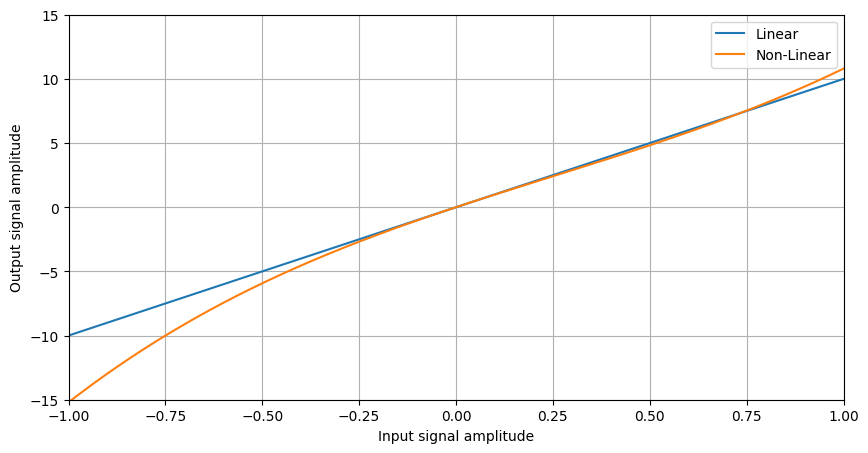

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(x, y1, label='Linear')
plt.plot(x, y2, label='Non-Linear')

plt.xlabel('Input signal amplitude')
plt.ylabel('Output signal amplitude')
plt.xlim(-1,1)
plt.ylim(-15,15)
plt.legend()
plt.grid(True)

plt.show()

As we can see from the plot, the output of the linear response provides exactly linear gain, whereas the non-linear response diverges as the input signal amplitude increases. This divergence will cause spurs to occur, with frequency components harmonically related to the input signal.

We can test this out further by simulating a non-linear device with a sinusoid input signal.

First we need to define the parameters and create the input signal.

In [4]:
fs = 10e3 # sample rate
T = np.arange(0,1,1/fs) 

Nfft = 1024 # number of FFT points.
fin = 100*(fs/Nfft) # input frequency

sin_x = np.sin(2*np.pi*fin*T)

print("fs: {:.2f} Hz".format(fs))
print("f_in: {:.2f} Hz".format(fin))

fs: 10000.00 Hz
f_in: 976.56 Hz


The input signal is a sine wave with a frequency of 976.56 Hz and a sample rate of 10 kHz. We will be using these parameters throughout the rest of this notebook.

We then create two output waveforms, one with a linear response, the other with a non-linear response. Note we are using the same coefficients we defined earlier.

In [5]:
sin_y_lin = a1*sin_x
sin_y_nonlin = a1*sin_x + a2*sin_x**2 + a3*sin_x**3

We can then plot the waveforms and compare them.

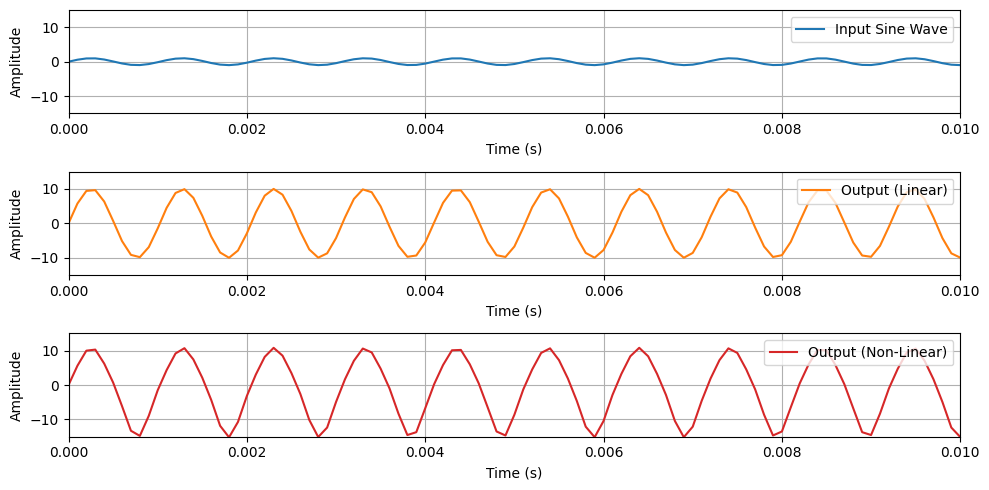

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(T, sin_x, label='Input Sine Wave', color='tab:blue')
plt.xlim(0,0.01)
plt.ylim(-15,15)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(T, sin_y_lin, label='Output (Linear)', color='tab:orange')
plt.xlim(0,0.01)
plt.ylim(-15,15)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(T, sin_y_nonlin, label='Output (Non-Linear)', color='tab:red')
plt.xlim(0,0.01)
plt.ylim(-15,15)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

As expected, the waveform with the linear response provides linear gain to the input signal. The non-linear response, however, has changed the signal slightly. 

While the difference between the linear and non-linear responses may be difficult to spot in the time domain, in the frequency domain it is a different matter.

In the cell below, we perform an FFT on both output signals to compare them in the frequency domain.

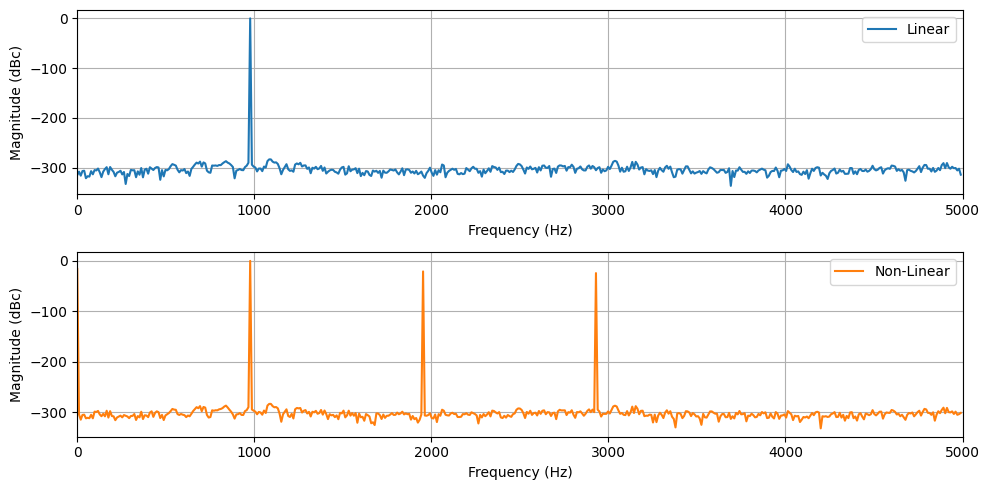

In [7]:
F_FFT = np.linspace(-fs/2, fs/2, Nfft, endpoint=False)

Y_nonlin = abs(np.fft.fftshift(np.fft.fft(sin_y_nonlin, Nfft)))
Y_nonlin_norm = Y_nonlin/Y_nonlin.max()
Y_lin =  abs(np.fft.fftshift(np.fft.fft(sin_y_lin, Nfft)))
Y_lin_norm = Y_lin/Y_lin.max()

plt.figure(figsize=(10,5))

plt.subplot(211)
plt.plot(F_FFT, 20*np.log10(Y_lin_norm), label='Linear', color='tab:blue')
plt.xlim(0,fs/2)
plt.ylabel("Magnitude (dBc)")
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(212)
plt.plot(F_FFT, 20*np.log10(Y_nonlin_norm), label='Non-Linear', color='tab:orange')
plt.xlim(0,fs/2)
plt.ylabel("Magnitude (dBc)")
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

As we can see, the simulated non-linear device has frequency components at 976.56 Hz (the fundamental), 1.95 kHz (the second harmonic), 2.93 kHz (the third harmonic), as well as a component at 0 Hz.

Manufacturer data sheets typically only include the second and third harmonics as they tend to be the most significant. However, higher order harmonics will exist to some extent in all non-linear devices, albeit usually at lower amplitudes.

We can easily calculate the location of any harmonic using the following equation:

$$HD_n = f_{in}n,$$

where $f_{in}$ is the input frequency and $n$ is the order of the harmonic (2, 3, 4...).

In the cell below, we use the equation above to calculate the second and third harmonics and plot them on a frequency plot.

f_in: 976.56 Hz
Harmonics: [1953.125, 2929.6875] (Hz)


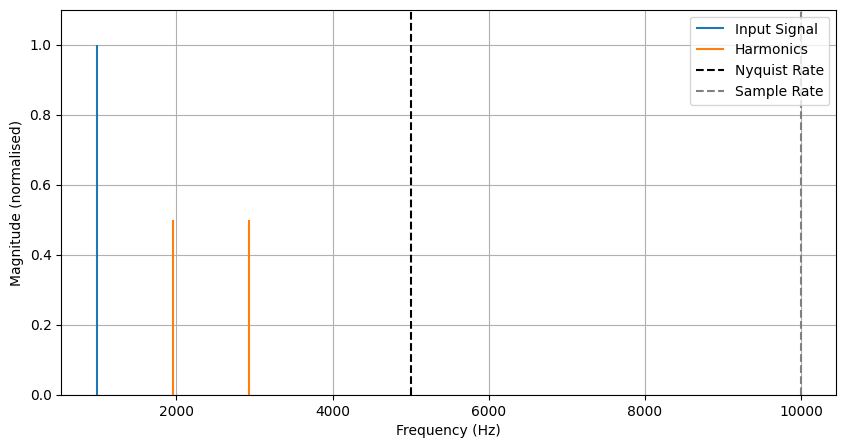

In [8]:
hd_ord = [2,3]

hd = [fin*n for n in hd_ord]
print("f_in: {:.2f} Hz".format(fin))
print("Harmonics: {} (Hz)".format(hd))

plt.figure(figsize=(10,5))

plt.vlines(fin, ymin=0, ymax=1, label='Input Signal', color='tab:blue')
plt.vlines(hd, ymin=0, ymax=0.5, label='Harmonics', color='tab:orange')
plt.vlines(fs/2, ymin=0, ymax=1.1, label='Nyquist Rate', color='black', linestyles='dashed')
plt.vlines(fs, ymin=0, ymax=1.1, label='Sample Rate', color='gray', linestyles='dashed')

plt.ylim(0,1.1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (normalised)")
plt.legend()
plt.grid(True)

plt.show()

As expected, both harmonics are at the same frequencies as the simulated device. Note that in the plot above the "magnitude" of the spurs is for demonstrative purposes only. The actual amplitude can only be found by direct measurement.

## 3. ADC Interleaving Spurs <a class="anchor" id="il_spurs"></a>

As discussed in the lectures, spurs can occur in interleaving ADCs due to mismatches between the sub-ADCs. The most prominent are DC offset, gain, and phase mismatches. 

As we did with a non-linear device before, we can simulate an interleaving ADC and see how these mismatches can introduce spurs to the output signal.

First we need to create a "continuous" input signal the ADC can sample. We do this by using a sample rate much higher than the original signal we used earlier.

In [9]:
fs_cont = fs*10
t_cont = np.arange(0,1,1/fs_cont)

sin_y_cont = np.sin(2*np.pi*fin*t_cont)

Now we have a "continuous" signal, we can set some parameters for the interleaving ADCs.

For this example, we will be using an interleaving factor, $M$, of 2. Additionally, we will set the sample rate of the sub-ADCs to $f_s/M = 10^3/2 = 5 kHz$.

In [10]:
M = 2 # interleaving factor
fs_sub_adc = fs/M # sub ADC sample rate

Since each sub-ADC needs to sample at different intervals, we need to calculate their individual sample points.

In [11]:
adc1_t_offset = round((fs_cont/fs_sub_adc)*((1-1)/M))
adc2_t_offset = round((fs_cont/fs_sub_adc)*((2-1)/M))  

t_sub_adc1 = np.arange(adc1_t_offset,len(sin_y_cont),fs_cont/fs_sub_adc, dtype=np.int16)
t_sub_adc2 = np.arange(adc2_t_offset,len(sin_y_cont),fs_cont/fs_sub_adc, dtype=np.int16)

print("ADC1 Sample Points: {}".format(t_sub_adc1[0:5]))
print("ADC2 Sample Points: {}".format(t_sub_adc2[0:5]))

ADC1 Sample Points: [ 0 20 40 60 80]
ADC2 Sample Points: [10 30 50 70 90]


We can see from the first 5 sample points of each ADC that they alternate.

Next we define the mismatch offsets between the sub-ADCs.

In [12]:
dc_offset = 0.2
gain_offset = 0.4
phase_offset = 0.3

We then sample the continuous signal at the sample points for each sub-ADC.

In [13]:
sub_adc1_out = sin_y_cont[t_sub_adc1]
sub_adc2_out = sin_y_cont[t_sub_adc2 + int(np.round(phase_offset * adc2_t_offset))] * (1-gain_offset) + dc_offset

Finally, we interleave the outputs from each sub-ADC.

In [14]:
adc_out = [None]*(len(sub_adc1_out) + len(sub_adc2_out))  
adc_out[::M] = sub_adc1_out
adc_out[1::M] = sub_adc2_out

We can now take the FFT of the interleaved output signal and view it in the frequency domain.

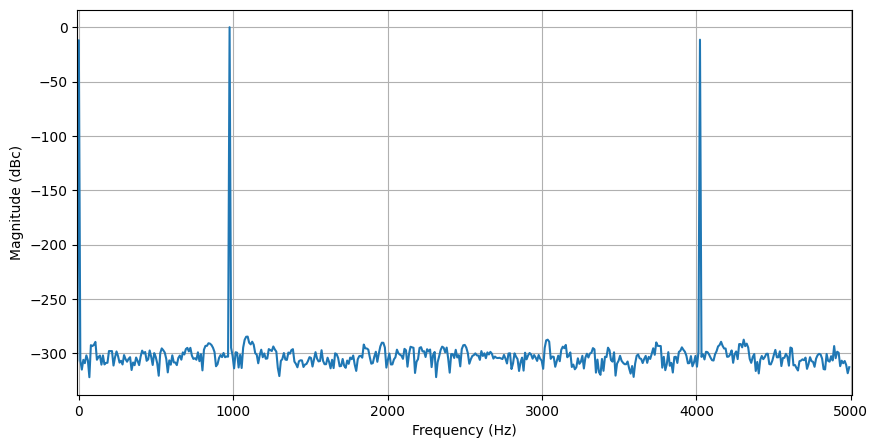

In [15]:
ADC_OUT = abs(np.fft.fftshift(np.fft.fft(adc_out, Nfft)))
ADC_OUT_NORM = ADC_OUT/ADC_OUT.max()

plt.figure(figsize=(10,5))
plt.plot(F_FFT,20*np.log10(ADC_OUT_NORM))

plt.xlim(-10,fs/2 + 10)
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBc)")

plt.show()

As shown in the above plot, the interleaved ADC we have simulated has frequency components at 976.56 Hz (the fundamental), 4.02 kHz (gain/time mismatch), and 0 Hz (DC offset interleaving spur). There should also be a DC offset spur at exactly $f_s/2$. However, due to the way we are plotting the frequency domain, this spur also appears at 0 Hz.

In the cell below, we formalise this simulation of the interleaved ADC into a generic function, which we will use later on in this notebook. 

In [16]:
def interleave_adc(M, fs_cont, fs_sub_adc, sig, dc_offset, gain_offset, phase_offset):
    
    if (len(dc_offset) and len(gain_offset) and len(phase_offset)) != M:
        raise RuntimeError("Offset values must be a list with length equal to the interleaving factor.")

    adc_t_offset = round(fs_cont/(fs_sub_adc*M))    
    sub_adc = [[]]*M 
    adc_len = 0
    
    for j in range(M):
        
        t = np.arange(j*adc_t_offset,len(sig),fs_cont/fs_sub_adc)

        for n in t:
            sub_adc[j] = sub_adc[j] + [sig[int(n) + (int(phase_offset[j] * adc_t_offset))] * (1-gain_offset[j]) + dc_offset[j]]
        adc_len += len(sub_adc[j])

    adc = [None]*adc_len
    
    for i in range(M):
        adc[i::M] = sub_adc[i]

    return np.array(adc)

Similar to harmonics, interleaving spurs are relatively easy to calculate. 

DC offset spurs (OIS) can be calculated by:

$$\frac{k}{M}f_s,$$

where $f_s$ is the sample rate, $M$ is the total number of interleaving ADCs, and $k$ is an integer $0,1,2..M-1$.

Gain and time interleaving spurs have a similar relationship but are also dependent on the frequency of the input signal.

$$\frac{k}{M}f_s \pm f_{in}.$$

Additionally, any harmonics present in the signal, caused by a non-linear response, will also be affected by the interleaving ADCs and introduce spurs. These can be calculated by

$$\frac{k}{M}f_s \pm HD_{n},$$

where $HD_n$ is the $n^{th}$ order harmonic.

In the following three sections we use these equations to calculate the spurs for a 4-interleaved ADC.

First, we need to change the interleaving factor, $M$, to 4, and update the sample rate of the sub-ADCs.

In [17]:
M = 4 # change interleaving factor
fs_sub_adc = fs/M # recalculate sub-ADC sample rate

### 3.1. DC Offset Interleaving Spurs <a class="anchor" id="dc_offset"></a>

fin: 976.56 Hz
OIS: [0.0, 2500.0, 5000.0, 7500.0] (Hz)


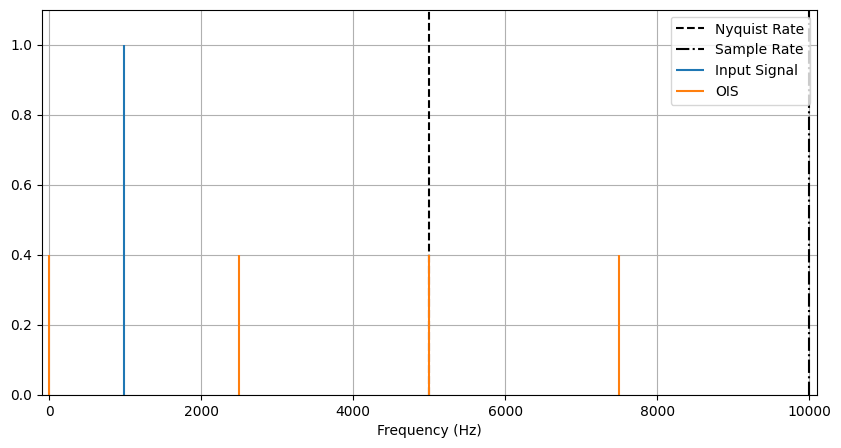

In [18]:
ois = [k/M * fs for k in range(M)]
print("fin: {:.2f} Hz".format(fin))
print("OIS: {} (Hz)".format(ois))

plt.figure(figsize=(10,5))

plt.vlines(fs/2, ymin=0, ymax=1.1, label='Nyquist Rate', color='black', linestyles='dashed')
plt.vlines(fs, ymin=0, ymax=1.1, label='Sample Rate', color='black', linestyles='dashdot')
plt.vlines(fin, ymin=0, ymax=1, label='Input Signal', color='tab:blue')
plt.vlines(ois, ymin=0, ymax=0.4, label='OIS', color='tab:orange')

plt.xlim(-100,fs+100)
plt.ylim(0,1.1)
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.grid(True)

plt.show()

### 3.2. Gain/Time Interleaving Spurs <a class="anchor" id="gain_time"></a>

fin: 976.56 Hz
GTIS: [3476.5625, 5976.5625, 8476.5625, 1523.4375, 4023.4375, 6523.4375] (Hz)


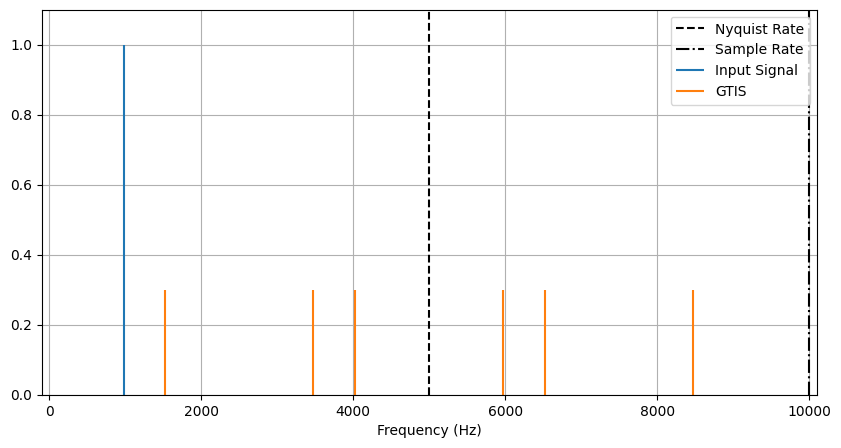

In [19]:
gtis_p = [k*fs/M + fin for k in range(1,M)]
gtis_n = [k*fs/M - fin for k in range(1,M)]

gtis = gtis_p + gtis_n
print("fin: {:.2f} Hz".format(fin))
print("GTIS: {} (Hz)".format(gtis))

plt.figure(figsize=(10,5))

plt.vlines(fs/2, ymin=0, ymax=1.1, label='Nyquist Rate', color='black', linestyles='dashed')
plt.vlines(fs, ymin=0, ymax=1.1, label='Sample Rate', color='black', linestyles='dashdot')
plt.vlines(fin, ymin=0, ymax=1, label='Input Signal', color='tab:blue')
plt.vlines(gtis, ymin=0, ymax=0.3, label='GTIS', color='tab:orange')

plt.xlim(-100,fs+100)
plt.ylim(0,1.1)
plt.xlabel("Frequency (Hz)")
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

### 3.3. Harmonic Interleaving Spurs <a class="anchor" id="harmonic"></a>

fin: 976.56 Hz
HD+IL: [1953.125, 4453.125, 6953.125, 9453.125, 1953.125, 546.875, 3046.875, 5546.875, 2929.6875, 5429.6875, 7929.6875, 10429.6875, 2929.6875, 429.6875, 2070.3125, 4570.3125] (Hz)


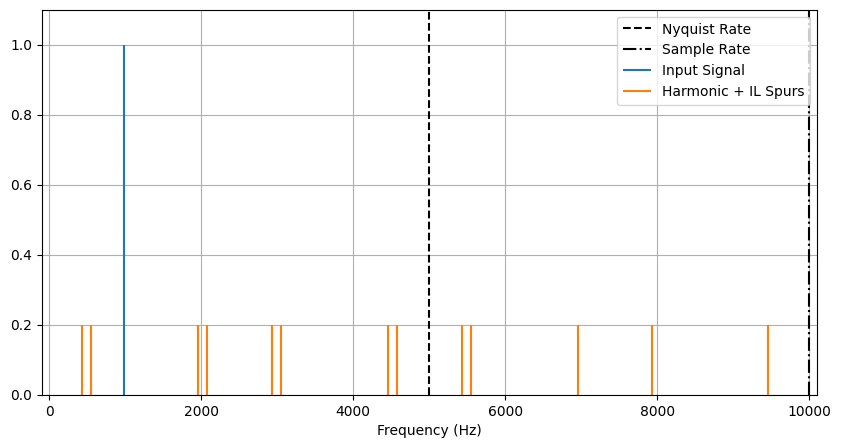

In [20]:
hd2_il_p = [spur + hd[0] for spur in ois]
hd2_il_n = [spur - hd[0] for spur in ois]

hd3_il_p = [spur + hd[1] for spur in ois]
hd3_il_n = [spur - hd[1] for spur in ois]

hd_il = hd2_il_p + hd2_il_n + hd3_il_p + hd3_il_n
hd_il = [abs(spur) for spur in hd_il]

print("fin: {:.2f} Hz".format(fin))
print("HD+IL: {} (Hz)".format(hd_il))

plt.figure(figsize=(10,5))

plt.vlines(fs/2, ymin=0, ymax=1.1, label='Nyquist Rate', color='black', linestyles='dashed')
plt.vlines(fs, ymin=0, ymax=1.1, label='Sample Rate', color='black', linestyles='dashdot')
plt.vlines(fin, ymin=0, ymax=1, label='Input Signal', color='tab:blue')
plt.vlines(hd_il, ymin=0, ymax=0.2, label='Harmonic + IL Spurs', color='tab:orange')

plt.xlim(-100,fs+100)
plt.ylim(0,1.1)
plt.xlabel("Frequency (Hz)")
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

As previously noted, the amplitudes of the spurs in these plots are for demonstrative purposes only in order to make it easier to differentiate between them. The actual amplitude of the spurs can only be determined through direct measurement.

## 4. Aliasing <a class="anchor" id="alias"></a>

ADC-related spurs with frequency components higher than the Nyquist rate ($f_s/2$) will fold back into the first Nyquist zone, increasing the likelihood that a spur will interfere with the signal of interest. A spur located in the first Nyquist zone will not be aliased and so its frequency content will not be changed, while a spur located in the second Nyquist zone will alias at a frequency of $f_s - f_{in}$. The spectrum between $0$ to $f_s$ is identical to that between $f_s$ to $2f_s$ and $2_fs$ to $3f_s$ and so on. We can use this information to easily calculate the location of any spur after aliasing.

Below, we define a function to determine the frequency of a spur after aliasing.

In [21]:
def alias(f, fs):
    f = abs(f) # any negative frequencies will also appear as positive frequencies
    f_alias = f % fs
    if f_alias > fs/2:
        f_alias = fs - f_alias
    return f_alias

We can then use this function to calculate the location of all the spurs we have calculated so far.

fin: 976.56 Hz
HD Alias: [2929.6875, 1953.125] (Hz)
OIS Alias: [0.0, 2500.0, 5000.0] (Hz)
GTIS Alias: [1523.4375, 3476.5625, 4023.4375] (Hz)
HD+IL Alias: [1953.125, 546.875, 4453.125, 3046.875, 429.6875, 2929.6875, 2070.3125, 4570.3125] (Hz)


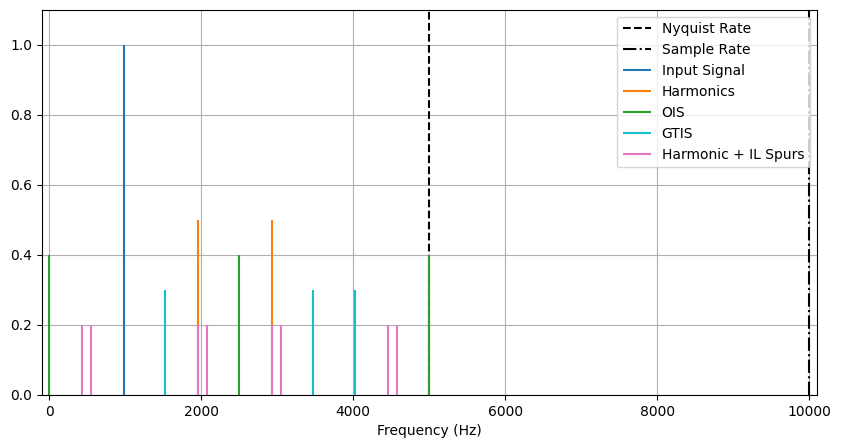

In [22]:
hd_alias = [alias(f, fs) for f in hd]
ois_alias = [alias(f, fs) for f in ois]
gtis_alias = [alias(f, fs) for f in gtis]
hd_il_alias = [alias(f, fs) for f in hd_il]

hd_alias = list(set(hd_alias))
ois_alias = list(set(ois_alias))
gtis_alias = list(set(gtis_alias))
hd_il_alias = list(set(hd_il_alias))

print("fin: {:.2f} Hz".format(fin))
print("HD Alias: {} (Hz)".format(hd_alias))
print("OIS Alias: {} (Hz)".format(ois_alias))
print("GTIS Alias: {} (Hz)".format(gtis_alias))
print("HD+IL Alias: {} (Hz)".format(hd_il_alias))

plt.figure(figsize=(10,5))

plt.vlines(fs/2, ymin=0, ymax=1.1, label='Nyquist Rate', color='black', linestyles='dashed')
plt.vlines(fs, ymin=0, ymax=1.1, label='Sample Rate', color='black', linestyles='dashdot')

plt.vlines(fin, ymin=0, ymax=1, label='Input Signal', color='tab:blue')
plt.vlines(hd_alias, ymin=0, ymax=0.5, label='Harmonics', color='tab:orange')
plt.vlines(ois_alias, ymin=0, ymax=0.4, label='OIS', color='tab:green')
plt.vlines(gtis_alias, ymin=0, ymax=0.3, label='GTIS', color='tab:cyan')
plt.vlines(hd_il_alias, ymin=0, ymax=0.2, label='Harmonic + IL Spurs', color='tab:pink')

plt.xlim(-100,fs+100)
plt.ylim(0,1.1)
plt.xlabel("Frequency (Hz)")
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

As we can see from this plot, the spectrum is now very busy, but there is ample space between the spurs closest to the input signal to filter them out.

## 5. Simulating a Non-Linear Interleaved ADC <a class="anchor" id="sim"></a>

Now that we understand how and why spurs occur, we can simulate an entire non-linear interleaved ADC and check the results against the spurs we calculated in the previous sections.

First we need to define the sub-ADC offsets. Remember, the values we are defining here are exaggerated for demonstrative purposes. In practice these values will typically be much lower, and the amplitude of spurs can only be accurately determined by direct measurement.

Since we have 4 sub-ADCs now we need to define a mismatch for each one.

In [23]:
dc_offset = [0, 0.01, 0.05, 0.02]
gain_offset = [0, 0.01, 0.02, 0.03]
phase_offset = [0, 0.1, 0.2, 0.01]

Then we can calculate the output of the simulated interleaved ADC using the `interleave_adc()` function we defined earlier. 

In [24]:
adc_out = interleave_adc(M, fs_cont, fs_sub_adc, sin_y_cont, dc_offset, gain_offset, phase_offset)

We can then simulate the response of the non-linear ADC.

First we need to redefine the coefficients. Note that we are using a value of 1 for `a1` as the ADC does not amplify the signal and we should expect an equivalent amplitude between input and output for a linear device.

In [25]:
a1 = 1
a2 = 0.05
a3 = 0.02

We can then use the equation we defined earlier to simulate a non-linear response from the ADC. 

In [26]:
adc_out_nonlin = a1*adc_out + a2*adc_out**2 + a3*adc_out**3

> It should be noted that this is not a true simulation of a non-linear ADC. The gain differentials between the input and output of an ADC occur from slightly different, but related, phenomena than in an amplifier. However, the end result is the same and for the purposes of this notebook we can calculate the non-linear response using the equation above. 

We can also add a little noise to the signal.

In [27]:
noise = np.random.normal(0,1,len(adc_out_nonlin))
adc_out_nonlin += noise*0.0001

Finally, we can take the FFT of the output signal and overlay the location of the aliased spurs we calculated a few cells above.

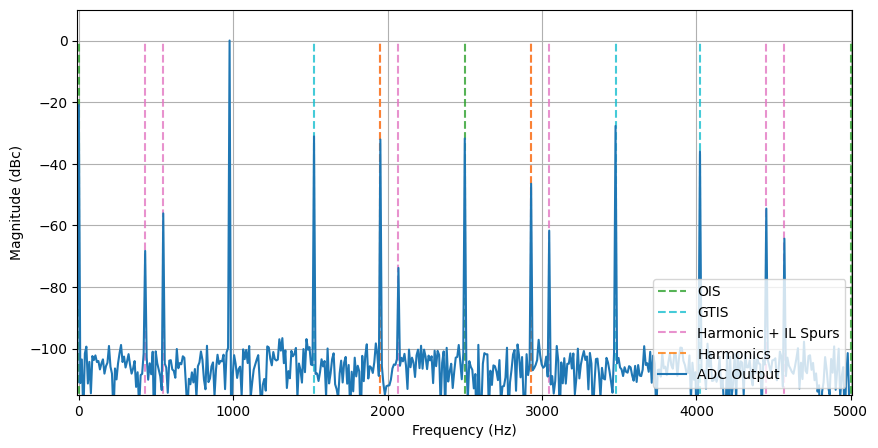

In [28]:
ADC_OUT = abs(np.fft.fftshift(np.fft.fft(adc_out_nonlin, Nfft)))
ADC_OUT_NORM = ADC_OUT/ADC_OUT.max()

alpha = 0.8

plt.figure(figsize=(10,5))

plt.vlines(ois_alias, ymin=-300, ymax=0, label='OIS', color='tab:green', alpha=alpha, linestyles='dashed')
plt.vlines(gtis_alias, ymin=-300, ymax=0, label='GTIS', color='tab:cyan', alpha=alpha, linestyles='dashed')
plt.vlines(hd_il_alias, ymin=-300, ymax=0, label='Harmonic + IL Spurs', color='tab:pink', alpha=alpha, linestyles='dashed')
plt.vlines(hd_alias, ymin=-300, ymax=0, label='Harmonics', color='tab:orange', alpha=alpha, linestyles='dashed')
plt.plot(F_FFT,20*np.log10(ADC_OUT_NORM), color='tab:blue', label='ADC Output')

plt.xlim(-10,fs/2 + 10)
plt.ylim(-320,10)
plt.ylim(-115,10)
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBc)")
plt.legend(loc="lower right")

plt.show()

As we can see from the plot, the location of the spurs are exactly where we had calculated them.

## 6. Filter Design <a class="anchor" id="filt_design"></a>

Now that we have our simulated output we can design a filter to suppress the surrounding spurs. First we need to determine the transition band for the filter. 

We can see from the above plot that the closest spurs to the input signal are the GTIS and harmonic interleaving spurs. We can print out these values to determine exactly how close they are.

In [29]:
gtis_alias.sort()
hd_il_alias.sort()

print("f_in: {} (Hz)".format(fin))
print("HD_IL: {} (Hz)".format(hd_il_alias))
print("GTIS: {} (Hz)".format(gtis_alias))

f_in: 976.5625 (Hz)
HD_IL: [429.6875, 546.875, 1953.125, 2070.3125, 2929.6875, 3046.875, 4453.125, 4570.3125] (Hz)
GTIS: [1523.4375, 3476.5625, 4023.4375] (Hz)


The closest harmonic interleaving spurs is at around 546 Hz, while the closest GTIS spur is around 1.5 kHz. A transition band of around 400 Hz should be more than sufficient.

Since there are spurs on either side of the input signal we will require a bandpass filter. 

Below we design a filter using the `firwin2` function from the SciPy library.

In [30]:
from scipy.signal import firwin2

num_taps = 51
bpf = firwin2(num_taps, [0,fin-400,fin,fin+400,fs/2], [0,0,1,0,0], fs=fs, window='blackman')

We can then view the response of filter in the frequency domain.

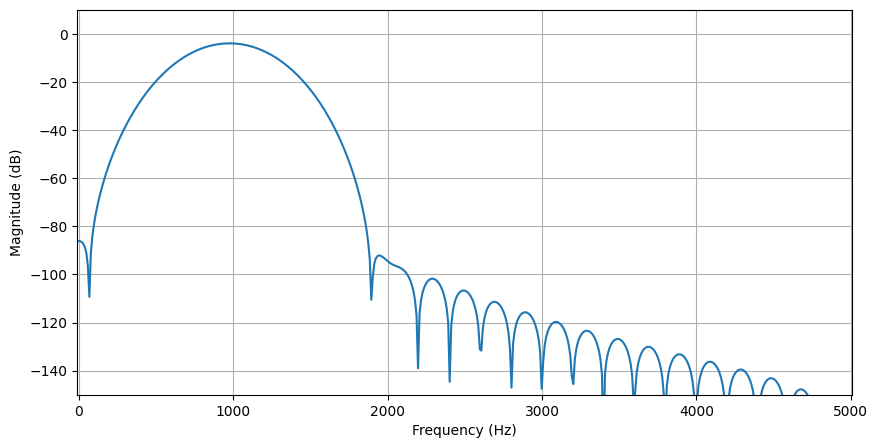

In [31]:
BPF = np.fft.fftshift(np.fft.fft(bpf, Nfft))

plt.figure(figsize=(10,5))

plt.plot(F_FFT,20*np.log10(abs(BPF)))

plt.xlim(-10,fs/2 + 10)
plt.ylim(-150,10)
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")

plt.show()

Finally we can apply the filter to the signal.

In [32]:
adc_out_filt = np.convolve(adc_out_nonlin, bpf, 'same')

We then take the FFT and plot the results in the frequency domain. We will overlay the original signal to see how well the filter has worked.

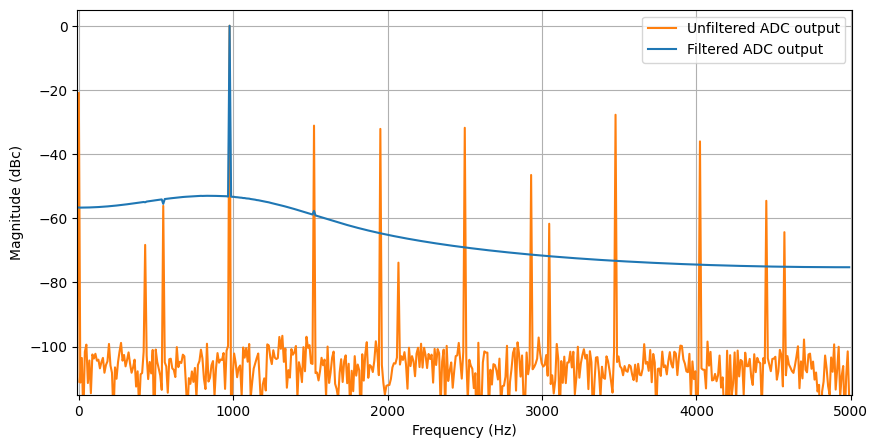

In [33]:
ADC_OUT_FILT = abs(np.fft.fftshift(np.fft.fft(adc_out_filt, Nfft)))
ADC_OUT_FILT_NORM = ADC_OUT_FILT/ADC_OUT_FILT.max()

plt.figure(figsize=(10,5))

plt.plot(F_FFT,20*np.log10(ADC_OUT_NORM), color='tab:orange', label='Unfiltered ADC output')
plt.plot(F_FFT,20*np.log10(ADC_OUT_FILT_NORM), color='tab:blue', label='Filtered ADC output')

plt.xlim(-10,fs/2 + 10)
plt.ylim(-115,5)
plt.grid(True)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBc)")
plt.legend()

plt.show()

We can see from the plot that the filter has sufficiently removed the spurs from the signal, leaving around -50 dBc.

## 7. Conclusion <a class="anchor" id="conclusion"></a>

In this notebook we dove a little deeper into how and why spurs occur within data converters and how to calculate where they will appear on the spectrum. We showed how to simulate the effects of non-linearity and interleaving, and compared the simulated results to the calculated ones.

In the next notebook, we present a frequency planning tool that uses the concepts introduced in this notebook to allow the user to quickly and efficiently calculate spurs given arbitrary input parameters.

---

[⬅️ Previous Notebook](13_complex_qam.ipynb) || [Next Notebook 🚀](15_fec_first_principles.ipynb)


---